In [120]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sat Apr  1 03:43:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 30

In [2]:
import pandas as pd
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Degraded:  12779
No Impact:  99361
Outage:  68808
Threatened:  28304



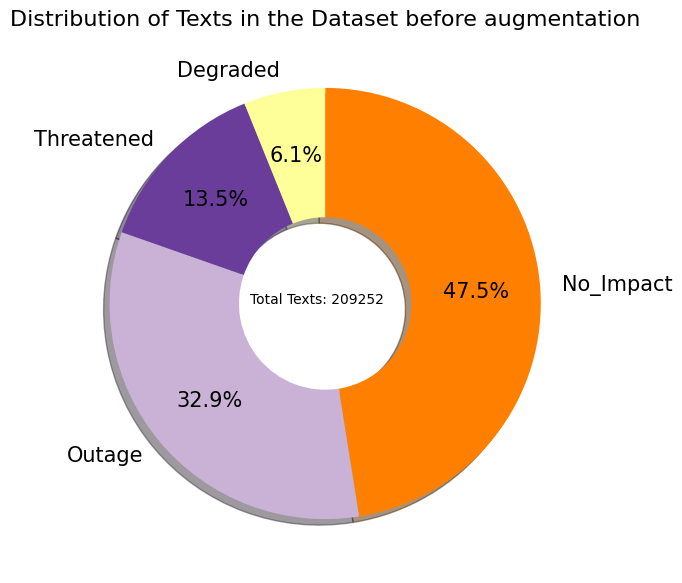

In [3]:
df = pd.read_csv("/home/sharedrive/nct_ticket_new/NCT_Tickets/csv_processed_raw/csv/cleaned_completed_train.csv")
df = df.dropna()
df['data_type'] = 'original'

print("Degraded: ", len(df[df["network_impact"] == "Degraded"]))
print("No Impact: ", len(df[df["network_impact"] == "No_Impact"]))
print("Outage: ", len(df[df["network_impact"] == "Outage"]))
print("Threatened: ", len(df[df["network_impact"] == "Threatened"]))

print()


df = df.sample(frac = 1) 

plt.figure(figsize = (7,7))
sorted_counts = df['network_impact'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Texts: {}'.format(df.shape[0]))
plt.title('Distribution of Texts in the Dataset before augmentation', fontsize = 16);

In [4]:
#Now I'll reduce 50% of the no_impact data with filter from 99637 data after applying filter

In [5]:
df_filtered = df[(df['network_impact'] != 'No_Impact') | ((df['_headline'].str.len() > 10) & (df['_description'].str.len() > 10))]

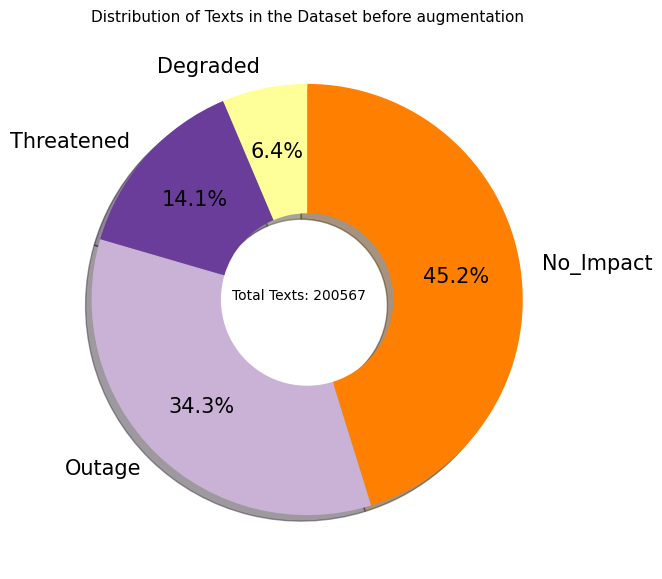

In [6]:
plt.figure(figsize = (7,7))
sorted_counts = df_filtered['network_impact'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Texts: {}'.format(df_filtered.shape[0]))
plt.title('Distribution of Texts in the Dataset before augmentation', fontsize = 11);

In [7]:
#So the number of data got reduced from 209764 to 200852 and 8912 rows from no_impact got removed

#The current number of No_Impact class rows are: 90584

In [8]:
print("Degraded: ", len(df_filtered[df_filtered["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_filtered[df_filtered["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_filtered[df_filtered["network_impact"] == "Outage"]))
print("Threatened: ", len(df_filtered[df_filtered["network_impact"] == "Threatened"]))

Degraded:  12779
No Impact:  90676
Outage:  68808
Threatened:  28304


In [9]:
#Before downsampling the data, I'll do the filtering with 20 chars in headline and 30 chars in description for No_Impact

In [10]:
df_filtered = df[(df['network_impact'] != 'No_Impact') | ((df['_headline'].str.len() > 20) & (df['_description'].str.len() > 30))]

In [11]:
print("Degraded: ", len(df_filtered[df_filtered["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_filtered[df_filtered["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_filtered[df_filtered["network_impact"] == "Outage"]))
print("Threatened: ", len(df_filtered[df_filtered["network_impact"] == "Threatened"]))

Degraded:  12779
No Impact:  65694
Outage:  68808
Threatened:  28304


In [12]:
#After this filter, we can see the no impact class got automatically reduced to 65000. Later we'll take 55000 from this filtered class

In [13]:
## Checking the same impact of filter for other classes

df_filtered_D = df_filtered[(df_filtered['network_impact'] != 'Degraded') | ((df_filtered['_headline'].str.len() > 10) & (df_filtered['_description'].str.len() > 10))]
print("Degraded: ", len(df_filtered_D[df_filtered_D["network_impact"] == "Degraded"]))

df_filtered_O = df_filtered[(df_filtered['network_impact'] != 'Outage') | ((df_filtered['_headline'].str.len() > 10) & (df_filtered['_description'].str.len() > 10))]
print("Outage: ", len(df_filtered_O[df_filtered_O["network_impact"] == "Outage"]))

## Checking the same impact of filter for other classes

df_filtered_T = df_filtered[(df_filtered['network_impact'] != 'Threatened') | ((df_filtered['_headline'].str.len() > 10) & (df_filtered['_description'].str.len() > 10))]
print("Threatened: ", len(df_filtered_T[df_filtered_T["network_impact"] == "Threatened"]))

Degraded:  10409
Outage:  63172
Threatened:  27005


In [14]:
# Data Reduction from each classes:

# *   No_Impact - 33667 after 2 filters
# *   Degraded - 2468
# *   Outage - 5823
# *   Threatened - 1299

In [15]:
#However, we'll proceed with the filtered data from only the No_Impact column which is named df_filtered

In [16]:
#Now I'll downsample 
#No_Impact to 55000 data
#Outage to 55000 after applying filter

In [17]:
df_filtered_downsampled = df_filtered.groupby('network_impact').apply(lambda x: x.sample(n=55000, random_state=42) if x.name == 'No_Impact' else x).reset_index(drop=True)


In [18]:
print("Degraded: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Outage"]))
print("Threatened: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Threatened"]))

Degraded:  12779
No Impact:  55000
Outage:  68808
Threatened:  28304


In [19]:
#Applying the 20 char filter on the outage class

df_filtered_downsampled = df_filtered_downsampled[(df_filtered_downsampled['network_impact'] != 'Outage') | ((df_filtered_downsampled['_headline'].str.len() > 10) & (df_filtered_downsampled['_description'].str.len() > 20))]

In [20]:
print("Degraded: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Outage"]))
print("Threatened: ", len(df_filtered_downsampled[df_filtered_downsampled["network_impact"] == "Threatened"]))

Degraded:  12779
No Impact:  55000
Outage:  54894
Threatened:  28304


In [21]:
# 5823 Outage data got filtered

# 14101 Outage got filtered after 10+20 chars condition

# Now I have to augment the minority 2 classes to get approximately 55000 data

# I'll generate a bit more data, but I'll then filter on the augmented column to match desired number


In [22]:
df_filtered_downsampled

,_headline,_description,network_impact,data_type
0,confirm legs,confirm legs node smt,Degraded,original
1,tdr cable cable repair,intermittent noise issue,Degraded,original
2,sandringham,pole transfer,Degraded,original
3,cut,oakbank rd vaughan,Degraded,original
4,loss to oss needs application restart,need preventive maintenence master lte server,Degraded,original
...,...,...,...,...
164886,bloor street dc power upgrade work order c e t,section work order c t dca rev sub section ...,Threatened,original
164887,x csde calgary card install cgw abcgy,ip core ops install ge plim fp card slot cgw...,Threatened,original
164888,pwo review pre loading c ep lt,pwo review pre loading c ep lt,Threatened,original
164889,lte roll access transmission augmentation man...,installation ericsson mini link tn ghz xm np...,Threatened,original


In [23]:
#See only data from filtered no impact class

In [24]:
df_no_impact = df_filtered_downsampled.loc[df_filtered_downsampled['network_impact'] == 'No_Impact']

In [25]:
df_no_impact.head(5)

,_headline,_description,network_impact,data_type
12779,dsr oim ldap auth integration mliumb,scope work integrate servers mliumc oss oim l...,No_Impact,original
12780,e halte routiere maintenance,algon brackets corrodes mt ldf ground kit m...,No_Impact,original
12781,sgsn mme backup cleanup western region,need cleanup backup western region avoid file ...,No_Impact,original
12782,dark splicing scarlett,pigtails splice dark fiber replaces fc connect...,No_Impact,original
12783,modulation profile submitted,modulation profile submitted currentdsd nsg rg...,No_Impact,original


In [26]:
#One thing I can now do is make a filter on the smaller classes and keep them in a dataframe. Then do the augmentation on the filtered data and at last, concat the data with smaller dataset

In [27]:
df_filtered_downsampled.to_csv("/home/sharedrive/nct_ticket_new/NCT_Tickets/csv_processed_raw/csv/preprocessed_data_before_augmentation.csv", index=False)

In [28]:
# data from degraded class
df_degraded = df_filtered_downsampled.loc[df_filtered_downsampled['network_impact'] == 'Degraded']

In [29]:
print("Degraded: ", len(df_degraded[df_degraded["network_impact"] == "Degraded"]))

Degraded:  12779


In [30]:
#Before testing the augmentation, lets try to make a filter in the Degraded class and keep 2 df for filtered and unfiltered data

In [31]:
df_degraded_filtered = df_degraded[(df_degraded['network_impact'] != 'Degraded') | ((df_degraded['_headline'].str.len() > 10) & (df_degraded['_description'].str.len() > 10))]


In [32]:
print("Degraded: ", len(df_degraded_filtered[df_degraded_filtered["network_impact"] == "Degraded"]))

Degraded:  10409


In [33]:
df_excluded_degraded = df_degraded[(df_degraded['network_impact'] == 'Degraded') & ((df_degraded['_headline'].str.len() <= 10) | (df_degraded['_description'].str.len() <= 10))]


In [34]:
print("Excluded Degraded: ", len(df_excluded_degraded[df_excluded_degraded["network_impact"] == "Degraded"]))

Excluded Degraded:  2370


In [35]:
print("Original filtered Degraded: ", len(df_degraded_filtered[df_degraded_filtered["network_impact"] == "Degraded"]))

Original filtered Degraded:  10409


In [36]:
syn_aug = naw.SynonymAug(aug_src='wordnet', model_path=None, name='Synonym_Aug', aug_min=10, aug_max=15, aug_p=0.3,
                         lang='eng',
                         stopwords=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None,
                         force_reload=False,
                         verbose=0)

anto_aug = naw.AntonymAug(name='Antonym_Aug', aug_min=10, aug_max=15, aug_p=0.3, lang='eng', stopwords=None,
                          tokenizer=None,
                          reverse_tokenizer=None, stopwords_regex=None, verbose=0)

random_aug = naw.RandomWordAug(action='delete', name='RandomWord_Aug', aug_min=10, aug_max=15, aug_p=0.3, stopwords=None,
                               target_words=None, tokenizer=None, reverse_tokenizer=None, stopwords_regex=None,
                               verbose=0)  #it deletes random words from the dataset

spell_aug = naw.SpellingAug(dict_path=None, name='Spelling_Aug', aug_min=10, aug_max=15, aug_p=0.3, stopwords=None,
                            tokenizer=None, reverse_tokenizer=None, include_reverse=True, stopwords_regex=None,
                            verbose=0)

split_aug = naw.SplitAug(name='Split_Aug', aug_min=10, aug_max=15, aug_p=0.3, min_char=4, stopwords=None, tokenizer=None,
                         reverse_tokenizer=None, stopwords_regex=None, verbose=0)

In [37]:
TOPK = 20  # default=100
ACT = 'insert'  # "substitute"

aug_distil_bert = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased',
    device='cuda',
    action=ACT, top_k=TOPK, aug_min =2) # Minimum number of word will be augmented.

aug_roberta = naw.ContextualWordEmbsAug(
    model_path='roberta-base',
    device='cuda',
    action="substitute", top_k=TOPK, aug_min =2) # Minimum number of word will be augmented.


aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    device='cuda',
    action="substitute", top_k=TOPK, aug_min =2) # Minimum number of word will be augmented.


aug_w2v = naw.WordEmbsAug(
    model_type='glove', model_path='./content/glove.6B.300d.txt',
    action="substitute" )


In [38]:
aug = naf.Sometimes([
     spell_aug, random_aug, syn_aug, aug_bert, aug_w2v, aug_roberta, aug_distil_bert
], aug_p=0.5)

In [39]:
degraded_df = df_degraded_filtered[df_degraded_filtered["network_impact"] == "Degraded"]

In [40]:
aug_times = 4  # It sets the number of augmentations to perform (aug_times) to 5.
augmented_df = []
min_len = 20

for index, row in tqdm(degraded_df.iterrows()):
    
    heading = aug.augment(row['_headline'], n=aug_times)
    description = aug.augment(row['_description'], n=aug_times)
    label = ["Degraded" for _ in range(aug_times)]


    for i in range(aug_times):
        tmp_dict = {}
        tmp_dict["_headline"] = heading[i]
        tmp_dict["_description"] = description[i]
        tmp_dict["network_impact"] = label[i]
        augmented_df.append(tmp_dict)

augmented_df = pd.DataFrame(augmented_df)
augmented_df['data_type'] = 'augmented'
degraded_df = pd.concat([augmented_df, degraded_df], ignore_index=True)

10409it [1:40:25,  1.73it/s]


In [41]:
degraded_df.describe()

,_headline,_description,network_impact,data_type
count,52045,52045,52045,52045
unique,35720,44107,1,2
top,।,।,Degraded,augmented
freq,1008,560,52045,41636


In [42]:
#Random Replacement Implementation on degraded from this blog -  https://towardsdatascience.com/nlp-data-augmentation-using-transformers-89a44a993bab

In [43]:
from transformers import pipeline
import random

unmasker = pipeline('fill-mask', model='bert-base-uncased')

def augment_text(row):
    # Split headline and description into separate word lists
    headline_words = row['_headline'].split()
    description_words = row['_description'].split()

    # Check that there are at least 3 words in each list
    if len(headline_words) < 3 or len(description_words) < 3:
        # If there aren't, return the original row unchanged
        return row

    # Choose a random insertion point between the first and last words
    rand_idx = random.randint(1, len(headline_words) + len(description_words) - 3)

    # Insert a [MASK] token at the chosen point
    if rand_idx < len(headline_words):
        headline_words.insert(rand_idx, '[MASK]')
    else:
        description_words.insert(rand_idx - len(headline_words), '[MASK]')

    # Join the word lists back into strings and pass them to the unmasker pipeline
    new_mask_sent = ' '.join(headline_words + description_words)
    augmented_text_list = unmasker(new_mask_sent)
    augmented_text = augmented_text_list[0]['sequence']

    # Split the augmented text back into headline and description
    new_headline, new_description = augmented_text.split(maxsplit=1)

    # Update the row with the augmented headline and description, and set the data_type column to 'augmented'
    row['_headline'] = new_headline
    row['_description'] = new_description
    row['data_type'] = 'augmented'

    return row


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
df_degraded_augmented_random = df_degraded_filtered.apply(augment_text, axis=1)

In [45]:
print("Augmented data for Degraded: ", len(df_degraded_augmented_random[df_degraded_augmented_random["network_impact"] == "Degraded"]))

Augmented data for Degraded:  10409


In [46]:
df_degraded_augmented_random


,_headline,_description,network_impact,data_type
0,confirm legs,confirm legs node smt,Degraded,original
1,tdr,cable cable repair system intermittent noise i...,Degraded,augmented
2,sandringham,pole transfer,Degraded,original
4,loss,to oss needs for application restart need prev...,Degraded,augmented
5,varad,ilom purple management netbackup recabling imp...,Degraded,augmented
...,...,...,...,...
12774,hardening node,signal flashing hardening node,Degraded,original
12775,troubleshoot,repair underground cable digs repair patterson...,Degraded,augmented
12776,cable,- cut ravensbourne cable cut ravensbourne,Degraded,augmented
12777,w,moosomin install install bbu install nd vendor...,Degraded,augmented


In [47]:

print("New Augmented data for Degraded: ", len(df_degraded_augmented_random[df_degraded_augmented_random["data_type"] == "augmented"]))

New Augmented data for Degraded:  8812


In [48]:
#So we can see we got 8714 new data from this augmentation technique, now we'll filter on it on the augmented flag.

In [49]:
df_degraded_filtered_augmented = df_degraded_augmented_random[(df_degraded_augmented_random['network_impact'] != 'Degraded') | ((df_degraded_augmented_random['_headline'].str.len() > 5) & (df_degraded_augmented_random['_description'].str.len() > 5))]



In [50]:
print("New Augmented data for Degraded: ", len(df_degraded_filtered_augmented[df_degraded_filtered_augmented["data_type"] == "augmented"]))


New Augmented data for Degraded:  3223


In [51]:
# now we have to do the below things:
# 1. concat the df_degraded_filtered_augmented with the output of conventional augmented output
# 2. concat the end output with the original excluded dataset
# 3. run another filter on overall dataset on the augmented datatype column 
# 4. repeat the same steps for the threatened class
# 5. concat the two minor classes final output with the pre-processed majority class and save the final augmented dataset

In [52]:
augmented_degraded_df = pd.concat([df_degraded_filtered_augmented, degraded_df], ignore_index=True)

In [53]:
augmented_degraded_df

,_headline,_description,network_impact,data_type
0,confirm legs,confirm legs node smt,Degraded,original
1,sandringham,pole transfer,Degraded,original
2,install,new lte rrus rrus a install new lte rrus rrus ...,Degraded,augmented
3,networkprefixlength,changed ipsc networkprefixlength change ericss...,Degraded,augmented
4,cable repair,eddington pl vaughan,Degraded,original
...,...,...,...,...
56860,hardening node,signal flashing hardening node,Degraded,original
56861,troubleshoot repair underground cable,dig repair patterson road barrie nika,Degraded,original
56862,cable cut ravensbourne,cable cut ravensbourne,Degraded,original
56863,w moosomin install,bbu install nd vendor install,Degraded,original


In [54]:
df_degraded_combined = pd.concat([augmented_degraded_df, df_excluded_degraded], ignore_index=True)

In [55]:
df_degraded_combined

,_headline,_description,network_impact,data_type
0,confirm legs,confirm legs node smt,Degraded,original
1,sandringham,pole transfer,Degraded,original
2,install,new lte rrus rrus a install new lte rrus rrus ...,Degraded,augmented
3,networkprefixlength,changed ipsc networkprefixlength change ericss...,Degraded,augmented
4,cable repair,eddington pl vaughan,Degraded,original
...,...,...,...,...
59230,cut,murray dr aurora,Degraded,original
59231,cut,yonge str midland,Degraded,original
59232,node smts,qam hardening,Degraded,original
59233,cut,c line orangeville,Degraded,original


In [56]:
df_degraded_combined.describe()

,_headline,_description,network_impact,data_type
count,59235,59235,59235,59235
unique,36662,48840,1,2
top,cut,।,Degraded,augmented
freq,1061,560,59235,44859


In [57]:
df_degraded_original = df_degraded_combined[df_degraded_combined['data_type'] == 'original']
df_degraded_augmented = df_degraded_combined[df_degraded_combined['data_type'] == 'augmented']

In [58]:
df_degraded_original.describe()


,_headline,_description,network_impact,data_type
count,14376,14376,14376,14376
unique,6354,9886,1,1
top,cut,qam hardening,Degraded,original
freq,1058,77,14376,14376


In [59]:
df_degraded_augmented.describe()

,_headline,_description,network_impact,data_type
count,44859,44859,44859,44859
unique,30382,38986,1,1
top,।,।,Degraded,augmented
freq,1008,560,44859,44859


In [60]:
df_filtered_degraded_final = df_degraded_augmented[(df_degraded_augmented['network_impact'] != 'Degraded') | ((df_degraded_augmented['_headline'].str.len() > 5) & (df_degraded_augmented['_description'].str.len() > 5))]

In [61]:
df_filtered_degraded_final.describe()

,_headline,_description,network_impact,data_type
count,29879,29879,29879,29879
unique,25039,28848,1,1
top,troubleshoot,repare,Degraded,augmented
freq,560,47,29879,29879


In [62]:
df_degraded_combined_final = pd.concat([df_filtered_degraded_final, df_degraded_original], ignore_index=True)

In [63]:
df_degraded_combined_final.describe()

,_headline,_description,network_impact,data_type
count,44255,44255,44255,44255
unique,31331,38712,1,2
top,cut,qam hardening,Degraded,augmented
freq,1058,77,44255,29879


In [64]:
print("Degraded: ", len(df_degraded_combined_final[df_degraded_combined_final["network_impact"] == "Degraded"]))

Degraded:  44255


In [65]:
df_filtered_downsampled = pd.read_csv("/home/sharedrive/nct_ticket_new/NCT_Tickets/csv_processed_raw/csv/preprocessed_data_before_augmentation.csv")

In [66]:
df_filtered_downsampled.describe()

,_headline,_description,network_impact,data_type
count,150977,150977,150977,150977
unique,72690,101949,4,1
top,node capacity augmentation,equipment tac perform remote eltek battery tes...,No_Impact,original
freq,9453,1203,55000,150977


In [67]:
# data from Threatened class
df_threatened = df_filtered_downsampled.loc[df_filtered_downsampled['network_impact'] == 'Threatened']

In [68]:
print("Threatened: ", len(df_threatened[df_threatened["network_impact"] == "Threatened"]))

Threatened:  28304


In [69]:
#Before testing the augmentation, lets try to make a filter in the Threatened class and keep 2 df for filtered and unfiltered data

In [70]:
df_threatened_filtered = df_threatened[(df_threatened['network_impact'] != 'Threatened') | ((df_threatened['_headline'].str.len() > 5) & (df_threatened['_description'].str.len() > 5))]


In [71]:
df_threatened_filtered.describe()

,_headline,_description,network_impact,data_type
count,28141,28141,28141,28141
unique,17516,19834,1,1
top,pwo preload w,equipment tac perform remote eltek battery tes...,Threatened,original
freq,522,1203,28141,28141


In [72]:
print("Threatened: ", len(df_threatened_filtered[df_threatened_filtered["network_impact"] == "Threatened"]))

Threatened:  28141


In [73]:
df_excluded_threatened = df_threatened[(df_threatened['network_impact'] == 'Threatened') & ((df_threatened['_headline'].str.len() <= 5) | (df_threatened['_description'].str.len() <= 5))]


In [74]:
print("Excluded Threatened: ", len(df_excluded_threatened[df_excluded_threatened["network_impact"] == "Threatened"]))

Excluded Threatened:  163


In [75]:
aug = naf.Sometimes([
     spell_aug, random_aug, syn_aug, aug_bert, aug_w2v, aug_roberta, aug_distil_bert
], aug_p=0.5)

In [76]:
threatened_df = df_threatened_filtered[df_threatened_filtered["network_impact"] == "Threatened"] 

In [77]:
threatened_df.describe()

,_headline,_description,network_impact,data_type
count,28141,28141,28141,28141
unique,17516,19834,1,1
top,pwo preload w,equipment tac perform remote eltek battery tes...,Threatened,original
freq,522,1203,28141,28141


In [79]:
aug_times = 1  # It sets the number of augmentations to perform (aug_times) to 5.
augmented_df_threatened = []
min_len = 20

for index, row in tqdm(threatened_df.iterrows()):
    
    heading = aug.augment(row['_headline'], n=aug_times)
    description = aug.augment(row['_description'], n=aug_times)
    label = ["Threatened" for _ in range(aug_times)]


    for i in range(aug_times):
        tmp_dict = {}
        tmp_dict["_headline"] = heading[i]
        tmp_dict["_description"] = description[i]
        tmp_dict["network_impact"] = label[i]
        augmented_df_threatened.append(tmp_dict)

augmented_df_threatened = pd.DataFrame(augmented_df_threatened)
augmented_df_threatened['data_type'] = 'augmented'
threatened_df_concat = pd.concat([augmented_df_threatened, threatened_df], ignore_index=True)

28141it [1:19:56,  5.87it/s]


In [80]:
threatened_df_concat

,_headline,_description,network_impact,data_type
0,data decom absent of person member second part...,tin can ei rmv greater than decommission statu...,Threatened,augmented
1,TX,are par de lte,Threatened,augmented
2,como as e es saas?,malicious nodes deleted deleted cisco rogers n...,Threatened,augmented
3,c,air group controllers air preloading configura...,Threatened,augmented
4,research e n t ii l adair i hlrs,rationale procedures were attached to gprs shi...,Threatened,augmented
...,...,...,...,...
56277,bloor street dc power upgrade work order c e t,section work order c t dca rev sub section ...,Threatened,original
56278,x csde calgary card install cgw abcgy,ip core ops install ge plim fp card slot cgw...,Threatened,original
56279,pwo review pre loading c ep lt,pwo review pre loading c ep lt,Threatened,original
56280,lte roll access transmission augmentation man...,installation ericsson mini link tn ghz xm np...,Threatened,original


In [81]:
threatened_df_concat.describe()

,_headline,_description,network_impact,data_type
count,56282,56282,56282,56282
unique,38451,45714,1,2
top,।,equipment tac perform remote eltek battery tes...,Threatened,augmented
freq,650,1203,56282,28141


In [82]:
#removing the degraded impact from this class
threatened_df_2 = threatened_df_concat[threatened_df_concat['network_impact'] == 'Threatened']

In [83]:
threatened_df_2.describe()

,_headline,_description,network_impact,data_type
count,56282,56282,56282,56282
unique,38451,45714,1,2
top,।,equipment tac perform remote eltek battery tes...,Threatened,augmented
freq,650,1203,56282,28141


In [84]:
#Random Replacement Implementation on threatened from this blog -  https://towardsdatascience.com/nlp-data-augmentation-using-transformers-89a44a993bab

In [85]:
from transformers import pipeline
import random

unmasker = pipeline('fill-mask', model='bert-base-uncased')

def augment_text(row):
    # Split headline and description into separate word lists
    headline_words = row['_headline'].split()
    description_words = row['_description'].split()

    # Check that there are at least 3 words in each list
    if len(headline_words) < 3 or len(description_words) < 3:
        # If there aren't, return the original row unchanged
        return row

    # Choose a random insertion point between the first and last words
    rand_idx = random.randint(1, len(headline_words) + len(description_words) - 3)

    # Insert a [MASK] token at the chosen point
    if rand_idx < len(headline_words):
        headline_words.insert(rand_idx, '[MASK]')
    else:
        description_words.insert(rand_idx - len(headline_words), '[MASK]')

    # Join the word lists back into strings and pass them to the unmasker pipeline
    new_mask_sent = ' '.join(headline_words + description_words)
    augmented_text_list = unmasker(new_mask_sent)
    augmented_text = augmented_text_list[0]['sequence']

    # Split the augmented text back into headline and description
    new_headline, new_description = augmented_text.split(maxsplit=1)

    # Update the row with the augmented headline and description, and set the data_type column to 'augmented'
    row['_headline'] = new_headline
    row['_description'] = new_description
    row['data_type'] = 'augmented'

    return row


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
df_threatened_augmented_random = df_threatened_filtered.apply(augment_text, axis=1)

In [87]:
print("Augmented data for Threatened: ", len(df_threatened_augmented_random[df_threatened_augmented_random["network_impact"] == "Threatened"]))

Augmented data for Threatened:  28141


In [88]:
df_threatened_augmented_random

,_headline,_description,network_impact,data_type
122673,decom,remove old hp s rtb pre paid ca ca ei rmv a de...,Threatened,augmented
122674,e,tx testing lte testing e tx testing lte,Threatened,augmented
122675,lte,nodes oss changeable nodes deleted rogers oss ...,Threatened,augmented
122676,glanford,park w new site transmission task involve ipra...,Threatened,augmented
122677,add,new pdpcp gprs profile rogers hlrs purpose doc...,Threatened,augmented
...,...,...,...,...
150972,bloor,street dc power upgrade work work order c e t ...,Threatened,augmented
150973,x,csde calgary card install cgw abcgy ip core op...,Threatened,augmented
150974,pwo,review pre loading c c ep lt pwo review pre lo...,Threatened,augmented
150975,lte,roll access transmission augmentation manitoba...,Threatened,augmented


In [89]:
print("New Augmented data for Threatened: ", len(df_threatened_augmented_random[df_threatened_augmented_random["data_type"] == "augmented"]))

New Augmented data for Threatened:  26080


In [90]:
df_threatened_augmented_random.describe()

,_headline,_description,network_impact,data_type
count,28141,28141,28141,28141
unique,3393,25181,1,2
top,c,config files loading pwo c ep lt,Threatened,augmented
freq,1291,157,28141,26080


In [91]:
#So we can see we got **** new data from this augmentation technique, now we'll filter on it on the augmented flag.

In [92]:
df_threatened_filtered_augmented = df_threatened_augmented_random[(df_threatened_augmented_random['network_impact'] != 'Threatened') | ((df_threatened_augmented_random['_headline'].str.len() > 5) & (df_threatened_augmented_random['_description'].str.len() > 5))]

print("New Augmented data for Threatened: ", len(df_threatened_filtered_augmented[df_threatened_filtered_augmented["data_type"] == "augmented"]))


New Augmented data for Threatened:  7464


In [93]:
# now we have to do the below things:
# 1. concat the df_degraded_filtered_augmented with the output of conventional augmented output
# 2. concat the end output with the original excluded dataset
# 3. run another filter on overall dataset on the augmented datatype column 
# 4. repeat the same steps for the threatened class
# 5. concat the two minor classes final output with the pre-processed majority class and save the final augmented dataset

In [94]:
augmented_threatened_df = pd.concat([df_threatened_filtered_augmented, threatened_df_2], ignore_index=True)

augmented_threatened_df.describe()

,_headline,_description,network_impact,data_type
count,65807,65807,65807,65807
unique,39529,52816,1,2
top,review,equipment tac perform remote eltek battery tes...,Threatened,augmented
freq,662,1203,65807,35605


In [95]:
df_threatened_combined = pd.concat([augmented_threatened_df, df_excluded_threatened], ignore_index=True)

df_threatened_combined

,_headline,_description,network_impact,data_type
0,glanford,park w new site transmission task involve ipra...,Threatened,augmented
1,timeout,class update disconenction mres pc timeout cla...,Threatened,augmented
2,moumsc epa,package fix issue csr imt package loaded pl...,Threatened,original
3,purple,oob eol mrv replacement mrvoob wi activity rep...,Threatened,augmented
4,mournc,- gpb card replacement mournc gpb card replace...,Threatened,augmented
...,...,...,...,...
65965,c nsd,config files loading pwo c ep lth,Threatened,original
65966,c nsd,config files loading pwo c ep lht,Threatened,original
65967,fcr,fcr,Threatened,original
65968,w,complete cable tray,Threatened,original


In [96]:
df_threatened_combined.describe()

,_headline,_description,network_impact,data_type
count,65970,65970,65970,65970
unique,39580,52920,1,2
top,review,equipment tac perform remote eltek battery tes...,Threatened,augmented
freq,662,1203,65970,35605


In [97]:
df_threatened_original = df_threatened_combined[df_threatened_combined['data_type'] == 'original']
df_threatened_augmented = df_threatened_combined[df_threatened_combined['data_type'] == 'augmented']

In [98]:
df_threatened_original.describe()

,_headline,_description,network_impact,data_type
count,30365,30365,30365,30365
unique,17576,19940,1,1
top,pwo preload w,equipment tac perform remote eltek battery tes...,Threatened,original
freq,522,1203,30365,30365


In [99]:
df_threatened_augmented.describe()

,_headline,_description,network_impact,data_type
count,35605,35605,35605,35605
unique,22073,32992,1,1
top,review,।,Threatened,augmented
freq,662,239,35605,35605


In [100]:
df_filtered_threatened_final = df_threatened_augmented[(df_threatened_augmented['network_impact'] != 'Threatened') | ((df_threatened_augmented['_headline'].str.len() > 10) & (df_threatened_augmented['_description'].str.len() > 10))]

In [101]:
# Just a backup if too much data gets lost 
df_filtered_threatened_final2 = df_threatened_augmented[(df_threatened_augmented['network_impact'] != 'Threatened') | ((df_threatened_augmented['_headline'].str.len() > 10) & (df_threatened_augmented['_description'].str.len() > 10))]

In [102]:
df_filtered_threatened_final.describe()

,_headline,_description,network_impact,data_type
count,15160,15160,15160,15160
unique,14338,15118,1,1
top,installation,chennai ipran,Threatened,augmented
freq,95,5,15160,15160


In [103]:
df_threatened_combined_final = pd.concat([df_filtered_threatened_final, df_threatened_original], ignore_index=True)

In [104]:
df_threatened_combined_final.describe()

,_headline,_description,network_impact,data_type
count,45525,45525,45525,45525
unique,31882,35056,1,2
top,pwo preload w,equipment tac perform remote eltek battery tes...,Threatened,original
freq,523,1203,45525,30365


In [105]:
print("Threatened: ", len(df_threatened_combined_final[df_threatened_combined_final["network_impact"] == "Threatened"]))

Threatened:  45525


In [106]:
#combining the augmented classes

df_augmented_combined_final = pd.concat([df_threatened_combined_final, df_degraded_combined_final], ignore_index=True)

In [107]:
df_augmented_combined_final.describe()

,_headline,_description,network_impact,data_type
count,89780,89780,89780,89780
unique,62822,73671,2,2
top,cut,equipment tac perform remote eltek battery tes...,Threatened,augmented
freq,1058,1203,45525,45039


In [108]:
#bringing the preprocessed dataframe for No_Impact and outage and making final df

In [109]:
df_filtered_downsampled.describe()

,_headline,_description,network_impact,data_type
count,150977,150977,150977,150977
unique,72690,101949,4,1
top,node capacity augmentation,equipment tac perform remote eltek battery tes...,No_Impact,original
freq,9453,1203,55000,150977


In [110]:
#removing the redundent classes from preprocessed data

df_filtered_downsampled = df_filtered_downsampled[df_filtered_downsampled['network_impact'] != 'Degraded']
df_filtered_downsampled = df_filtered_downsampled[df_filtered_downsampled['network_impact'] != 'Threatened']

df_filtered_downsampled.describe()

,_headline,_description,network_impact,data_type
count,109894,109894,109894,109894
unique,50299,72793,2,1
top,node capacity augmentation,current information currentpg cmts ymus cmt...,No_Impact,original
freq,9442,459,55000,109894


In [111]:
#now concatenate all four final classes

In [112]:
df_final = pd.concat([df_augmented_combined_final, df_filtered_downsampled], ignore_index=True)

In [113]:
df_final.describe()

,_headline,_description,network_impact,data_type
count,199674,199674,199674,199674
unique,111769,145855,4,2
top,node capacity augmentation,equipment tac perform remote eltek battery tes...,No_Impact,original
freq,9453,1203,55000,154635


Degraded:  44255
No Impact:  55000
Outage:  54894
Threatened:  45525



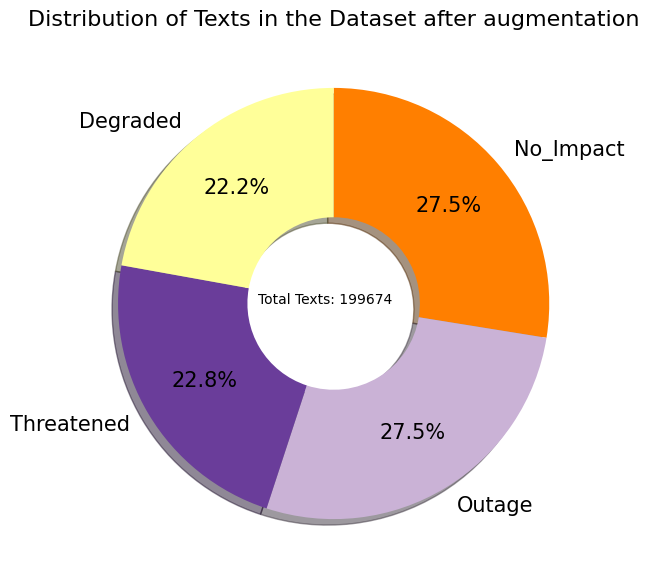

In [114]:
print("Degraded: ", len(df_final[df_final["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_final[df_final["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_final[df_final["network_impact"] == "Outage"]))
print("Threatened: ", len(df_final[df_final["network_impact"] == "Threatened"]))

print()


df = df_final.sample(frac = 1) 

plt.figure(figsize = (7,7))
sorted_counts = df['network_impact'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Texts: {}'.format(df.shape[0]))
plt.title('Distribution of Texts in the Dataset after augmentation', fontsize = 16);

In [115]:
df_degraded_combined.describe()

,_headline,_description,network_impact,data_type
count,59235,59235,59235,59235
unique,36662,48840,1,2
top,cut,।,Degraded,augmented
freq,1061,560,59235,44859


Degraded:  44255
No Impact:  55000
Outage:  54894
Threatened:  45525



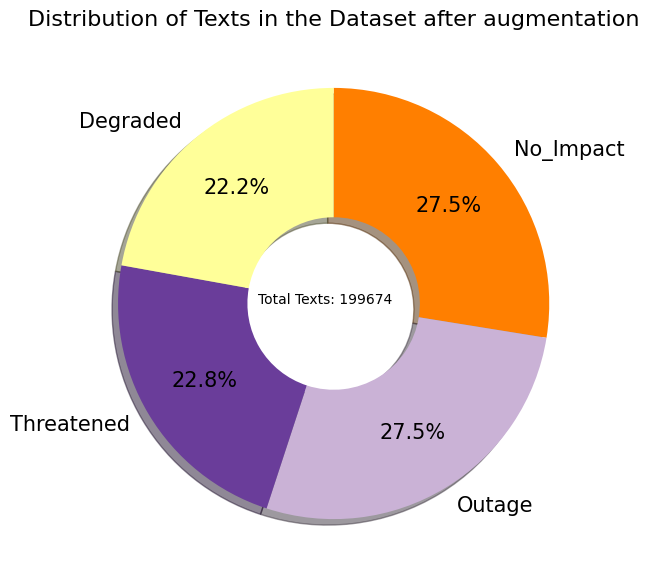

In [116]:
print("Degraded: ", len(df_final[df_final["network_impact"] == "Degraded"]))
print("No Impact: ", len(df_final[df_final["network_impact"] == "No_Impact"]))
print("Outage: ", len(df_final[df_final["network_impact"] == "Outage"]))
print("Threatened: ", len(df_final[df_final["network_impact"] == "Threatened"]))

print()


df = df_final.sample(frac = 1) 

plt.figure(figsize = (7,7))
sorted_counts = df['network_impact'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Texts: {}'.format(df.shape[0]))
plt.title('Distribution of Texts in the Dataset after augmentation', fontsize = 16);

In [117]:
df_final.to_csv("/home/sharedrive/nct_ticket_new/NCT_Tickets/csv_processed_raw/csv/final_augmentation_training.csv", index=False)

In [119]:
print("Original Data Rows: ", len(df_final[df_final["data_type"] == "original"]))
print("Augmented Data Rows: ", len(df_final[df_final["data_type"] == "augmented"]))

Original Data Rows:  154635
Augmented Data Rows:  45039
